# Music Genre Classification

* Install Miniconda from their website
* Put Conda on PATH during the install
* Update conda - Terminal Command: conda update conda
* Clone the Github repository (send Tim or I your github username if you haven’t yet).
* Load environment.yaml into conda environment (this will take a while to download) - Terminal Command: conda env create -n mus2vid -f environment.yaml

## Download CSV file with Classical Dataset and Parse

In [2]:
import pandas as pd
import re

classical_data = pd.read_csv('classical_dataset.csv')
# print (classical_data)

wavs = list(classical_data['audio_filename'])
genres = list(classical_data['Genre'])
for i in range(0, len(wavs)):
    wavs[i] = re.sub("[0-9]+/", "", wavs[i])
    wavs[i] = re.sub("_wav", "", wavs[i])

genre_list = []
for i in genres:
    if not i in genre_list:
        genre_list.append(i)

genre_ints = []
for i in range(len(genres)):
    j = 0
    while (not(genres[i] == genre_list[j])):
        j += 1
    genre_ints.append(j)
    

print(wavs)
print(genres)
print (genre_ints)
print(genre_list)
print(len(wavs))

['MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018--1.wav', 'MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MID--AUDIO_03_R2_2008--2.wav', 'MIDI-Unprocessed_066_PIANO066_MID--AUDIO-split_07-07-17_Piano-e_3-02--3.wav', 'MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MID--AUDIO_21_R1_2004_01_Track01.wav', 'MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MID--AUDIO_17_R1_2006_04_Track04.wav', 'MIDI-Unprocessed_07_R1_2009_04-05_ORIG_MID--AUDIO_07_R1_2009_07_R1_2009_04_WAV.wav', 'MIDI-Unprocessed_11_R1_2009_06-09_ORIG_MID--AUDIO_11_R1_2009_11_R1_2009_07_WAV.wav', 'ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_19_R2_2013--3.wav', 'MIDI-Unprocessed_02_R1_2009_03-06_ORIG_MID--AUDIO_02_R1_2009_02_R1_2009_04_WAV.wav', 'MIDI-Unprocessed_02_R1_2009_03-06_ORIG_MID--AUDIO_02_R1_2009_02_R1_2009_05_WAV.wav', 'MIDI-Unprocessed_15_R1_2011_MID--AUDIO_R1-D6_09_Track09.wav', 'MIDI-Unprocessed_19_R1_2006_01-07_ORIG_MID--AUDIO_19_R1_2006_04_Track04.wav', 'ORIG-MIDI_02_7_10_13_Group_MID--AUDIO_11_R3_2013--3.wav', 'MIDI-Unprocessed_09_R1_2011_

Match 15 second clips to Genre

In [5]:
import os
import re

path = "wav_clips/"
audio_clips = os.listdir(path)
clip_genres = []

for clip in audio_clips:
    match_str = re.sub("^[0-9]+_", "", clip)
    wav_index = wavs.index(match_str)
    clip_genres.append(genre_ints[wav_index])

print(clip_genres)

[3, 3, 1, 1, 3, 2, 1, 1, 3, 2, 2, 2, 1, 1, 3, 1, 1, 2, 3, 2, 1, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 1, 1, 3, 2, 2, 1, 1, 3, 1, 2, 1, 1, 3, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 0, 3, 2, 2, 1, 1, 2, 2, 0, 1, 1, 1, 3, 2, 2, 1, 1, 2, 0, 1, 0, 2, 2, 2, 2, 2, 2, 2, 1, 1, 3, 2, 1, 0, 0, 3, 3, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 1, 3, 2, 2, 2, 3, 2, 1, 3, 2, 1, 2, 2, 1, 3, 1, 3, 2, 2, 3, 2, 2, 0, 2, 2, 1, 1, 1, 3, 2, 1, 2, 1, 1, 0, 3, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 3, 2, 1, 2, 3, 2, 2, 2, 1, 1, 3, 2, 2, 3, 2, 2, 2, 3, 2, 1, 1, 3, 2, 1, 3, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 1, 3, 2, 2, 2, 2, 1, 1, 3, 2, 1, 0, 2, 1, 1, 3, 3, 2, 1, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 1, 1, 3, 2, 1, 3, 0, 2, 2, 1, 3, 2, 2, 2, 3, 2, 2, 3, 2, 1, 3, 2, 0, 1, 3, 2, 2, 1, 2, 1, 1, 0, 3, 2, 1, 1, 2, 3, 3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 0, 3, 2, 2, 1, 3, 2, 2, 1, 3, 2, 1, 1, 

## Process wav files and convert to MIDI objects


In [9]:
import pickle
import lzma
import pretty_midi as pm
import pandas as pd
import numpy as np
import tensorflow as tf
from basic_pitch.inference import predict as bp_predict
from basic_pitch import ICASSP_2022_MODEL_PATH
BASIC_PITCH_MODEL = tf.saved_model.load(str(ICASSP_2022_MODEL_PATH))

def predict(filestr):
    """
    Makes a Basic Pitch prediction with the global parameters above given an input audio file.
    
    Parameters:
        filestr (str): The path to the input audio file.
        
    Returns:
        PrettyMIDI object containing predicted MIDI notes.
    """
    # Run prediction
    STD_ONSET = 0.3
    STD_FRAME = 0.2
    STD_MIN_NOTE_LEN = 50
    STD_MIN_FREQ = None
    STD_MAX_FREQ = 3000
    
    model_output, midi_data, note_events = bp_predict(
        filestr,
        BASIC_PITCH_MODEL,
        STD_ONSET,
        STD_FRAME,
        STD_MIN_NOTE_LEN,
        STD_MIN_FREQ,
        STD_MAX_FREQ
    ) # midi_data is the PrettyMIDI object corresponding to the prediction
    return midi_data

def get_matched_midi(audio, genres):
    """
    Creates pretty-midi objects from input .wav files
    Matches each MIDI object with a composition year based on the years list

    Parameters:
        audio (list): list of audio filepaths.
        years (list): list of (approximate) composition years for each .wav file

    Returns:
        pandas.DataFrame: A DataFrame containing the pretty_midi obj and the corresponding composition year
    """
    prettys = [] # list of pretty_midi objects

    iters = 0
    for i in range(len(audio)):
        print(str(iters) + "/" + str(len(audio)))
        iters += 1

        midi_obj = predict("wav_clips/" + audio[i])
        # midi_obj = pm.PrettyMIDI(audio[i])
        prettys.append(midi_obj)

    df = pd.DataFrame({'midi_obj': prettys, 'genre': genres})

    return df
print(len(audio_clips))
matched_midi_df = get_matched_midi(audio_clips, clip_genres)

# Optionally save the matched_midi_df DataFrame as a pickle file    
with lzma.open("matched_midi_1.xz", "wb") as f:
    pickle.dump(matched_midi_df[0:19999], f)
with lzma.open("matched_midi_2.pkl", "wb") as f:
    pickle.dump(matched_midi_df[20000:39999], f)
with lzma.open("matched_midi_3.pkl", "wb") as f:
    pickle.dump(matched_midi_df[40000:], f)

# Print the first few rows
print(matched_midi_df.head())


48460
0/48460
Predicting MIDI for wav_clips/0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014--1.wav...
1/48460
Predicting MIDI for wav_clips/0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014--2.wav...
2/48460
Predicting MIDI for wav_clips/0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014--3.wav...
3/48460
Predicting MIDI for wav_clips/0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014--5.wav...
4/48460
Predicting MIDI for wav_clips/0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014--1.wav...
5/48460
Predicting MIDI for wav_clips/0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014--2.wav...
6/48460
Predicting MIDI for wav_clips/0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014--4.wav...
7/48460
Predicting MIDI for wav_clips/0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014--5.wav...
8/48460
Predicting MIDI for wav_clips/0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014--2.wav...
9/48460
Predicting MIDI for wav_clips/0_MIDI-UNPROCESSED_01-03_R1_2

KeyboardInterrupt: 

In [18]:
import pandas as pd
import numpy as np
import librosa
import pickle
import lzma


def get_matched_librosa(audio, genres):
    """
    Takes in a list of audio filepaths and creates a dataframe column of mel spectrograms with matched
    genres, similar to the midi object dataframe
    """
    ys = []
    srs = []

    iters = 0
    for file in audio:
        print(str(iters) + "/" + str(len(audio)))
        iters += 1

        y, sr = librosa.load("wav_clips/" + file)
        ys.append(y)
        srs.append(srs)

    df = pd.DataFrame({'y': ys, 'sr': srs, 'genre': genres})
    
    return df

matched_librosa_df = get_matched_librosa(audio_clips[:100], clip_genres[:100])



with lzma.open("matched_librosa.xz", "wb") as f:
    pickle.dump(matched_librosa_df, f)


0/100
1/100
2/100
3/100
4/100
5/100
6/100
7/100
8/100
9/100
10/100
11/100
12/100
13/100
14/100
15/100
16/100
17/100
18/100
19/100
20/100
21/100
22/100
23/100
24/100
25/100
26/100
27/100
28/100
29/100
30/100
31/100
32/100
33/100
34/100
35/100
36/100
37/100
38/100
39/100
40/100
41/100
42/100
43/100
44/100
45/100
46/100
47/100
48/100
49/100
50/100
51/100
52/100
53/100
54/100
55/100
56/100
57/100
58/100
59/100
60/100
61/100
62/100
63/100
64/100
65/100
66/100
67/100
68/100
69/100
70/100
71/100
72/100
73/100
74/100
75/100
76/100
77/100
78/100
79/100
80/100
81/100
82/100
83/100
84/100
85/100
86/100
87/100
88/100
89/100
90/100
91/100
92/100
93/100
94/100
95/100
96/100
97/100
98/100
99/100


In [1]:
import pickle

# If saved, load matched_midi_df from the saved pickle file
with open('matched_midi.pkl', 'rb') as f:
    matched_midi_df = pickle.load(f)
print(matched_midi_df.head())

   Unnamed: 0                                           midi_obj  genre
0           0  <pretty_midi.pretty_midi.PrettyMIDI object at ...      3
1           1  <pretty_midi.pretty_midi.PrettyMIDI object at ...      3
2           2  <pretty_midi.pretty_midi.PrettyMIDI object at ...      1
3           3  <pretty_midi.pretty_midi.PrettyMIDI object at ...      1
4           4  <pretty_midi.pretty_midi.PrettyMIDI object at ...      3


## Extract Midi Files Features

In [7]:
import pickle
import numpy as np
import pretty_midi
from sklearn.utils import resample
from chord_detection.chord_detection_pyfile import *

def normalize_features(features):
    """
    Normalizes the features to the range [-1, 1].

    Parameters:
        features (list of float): The array of features.

    Returns:
        list of float: Normalized features.
    """
    # Normalize each feature based on its specific range
    tempo = (features[0] - 150) / 300
    num_sig_changes = (features[1] - 2) / 10
    resolution = (features[2] - 260) / 400
    time_sig_1 = (features[3] - 3) / 8
    time_sig_2 = (features[4] - 3) / 8
    melody_complexity = (features[5] - 0) / 10
    melody_range = (features[6] - 0) / 80

    # Normalize pitch class histogram
    pitch_class_hist = [((f - 0) / 100) for f in features[7:-1]]

    # Return the normalized feature vector
    return [tempo, num_sig_changes, resolution, time_sig_1, time_sig_2, melody_complexity, melody_range] + pitch_class_hist

def get_features(midi_obj, all_chords):
    """
    Extracts specific features from a PrettyMIDI object given its path using the pretty_midi library.
    Handle any potential errors with MIDI files appropriately.

    Parameters:
        midi_obj: the PrettyMIDI object

    Returns:
        list of float: The extracted features.
    """
    
    # tempo: the estimated tempo of the audio file
    tempo = midi_obj.estimate_tempo()

    # num_sig_changes: the number of time signature changes in the audio file
    num_sig_changes = len(midi_obj.time_signature_changes)

    # resolution: the time resolution of the audio file (in ticks per beat)
    resolution = midi_obj.resolution


    # Extract time signature information
    ts_changes = midi_obj.time_signature_changes
    ts_1, ts_2 = 4, 4
    if len(ts_changes) > 0:
        ts_1 = ts_changes[0].numerator
        ts_2 = ts_changes[0].denominator
    
    # Extract melody-related features
    # melody: a pitch class histogram of the audio file
    melody = midi_obj.get_pitch_class_histogram()
    # melody_complexity: the number of unique pitch classes in the melody
    melody_complexity = np.sum(melody > 0)
    # melody_range: the range of pitch classes in the melody
    melody_range = np.max(melody) - np.min(melody)
    # OPTIONAL feature melody_contour: the temporal evolution of pitch content in the audio file
    # melody_contour = librosa.feature.tempogram(y=file.fluidsynth(fs=16000), sr=16000, hop_length=512)
    # melody_contour = np.mean(melody_contour, axis=0)
    # chroma: a chroma representation of the audio file
    chroma = midi_obj.get_chroma()
    # pitch_class_hist: the sum of the chroma matrix along the pitch axis
    pitch_class_hist = np.sum(chroma, axis=1)
    # Chord detection functions
    # notes = consolidate_notes(midi_obj)
    # chords = calculate_song_chords(notes, all_chords=all_chords)
    # key = estimate_key(chords)
    # changes = chord_changes(chords, midi_obj)
    # grams = n_grams(chords, 3)

    features = normalize_features([tempo, num_sig_changes, resolution, ts_1,
                            ts_2, melody_complexity, melody_range] + list(pitch_class_hist))
    # features.append(key)
    # features.append(changes)
    # features.append(grams)

    return features

def extract_midi_features(midi_df):
    """
    Extracts features and labels from MIDI objects listed in the DataFrame and concatenates the
    features with their labels into a matrix.

    Since the dataset is inherently unbalanced in terms of genre distribution, oversampling and 
    undersampling can be used to achieve a more balanced representation of features for each genre.

    Parameters:
        path_df (pandas.DataFrame): A DataFrame with pretty-midi objects and their composition years.

    Returns:
        numpy.ndarray: A matrix of features along with labels.
    """
    all_chords = generate_chord_list()
    all_features = []  # List to store all extracted features
    iters = 0
    for index, row in midi_df.iterrows():
        print(iters)
        iters += 1

        midi_obj = row['midi_obj']
        if(midi_obj.get_end_time() > 5):
            obj_features = get_features(midi_obj, all_chords)
            obj_features.append(row['genre'])
            all_features.append(obj_features)
    # Return the numpy array of all extracted features along with corresponding years
    return np.array(all_features)


# def balance_data(midi_df, genre_list):
    """
    Balances the dataframe of midi objects to have the same amount in each subgenre by oversampling smaller genres.
    
    Currently commented out because the data should be balanced after partitioning to avoid leakage

    Parameters:
        midi_df: unbalanced dataframe of all the midi objects and genres from the maestro dataset
        genre_list: list of the genres in the dataset
    
        Returns:
        Longer dataframe with equal samples from each genre
    """
#     # Calculate the number of music samples in the genre with the most samples
#     genre_balance = np.zeros(len(genre_list))
#     for index, row in midi_df.iterrows():
#         genre_balance[row['genre']] += 1
#     max_samples = int(max(genre_balance))

#     # resample other genres to have that many samples
#     df_list = []
#     for genre_num in range(len(genre_list)):
#         df_list.append(midi_df[midi_df['genre'] == genre_num])

#     balanced_list = []
#     for df in df_list:
#         if (len(df) != max_samples):
#             df = resample(df, random_state=42, n_samples=max_samples, replace=True)
#         balanced_list.append(df)

#     balanced_df = pd.concat(balanced_list)

#     return balanced_df

# Balance the input data
# balanced_df = balance_data(matched_midi_df, genre_list)

# Call the extract_midi_features function with the appropriate path DataFrame to extract the MIDI 
# file features and obtain the feature-label matrix
labeled_features = extract_midi_features(matched_midi_df)
# Print the labeled features
print(labeled_features)
print(labeled_features.shape)

# Optionally store the feature-label matrix as a pickle file for further use
with open('labeled_features_chords.pkl', 'wb') as f:
    pickle.dump(labeled_features, f)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
[[ 3.13145296e-01 -2.00000000e-01 -1.00000000e-01 ...  4.10023379e+02
   2.04936621e+02  3.00000000e+00]
 [ 1.02596494e-01 -2.00000000e-01 -1.00000000e-01 ...  6.75040000e+02
   0.00000000e+00  3.00000000e+00]
 [ 2.41029510e-01 -2.00000000e-01 -1.00000000e-01 ...  5.33670000e+02
   1.06721000e+03  1.00000000e+00]
 ...
 [ 1.79995888e-01 -2.00000000e-01 -1.00000000e-01 ...  4.57610000e+02
   0.00000000e+00  2.00000000e+00]
 [ 2.55550987e-01 -2.00000000e-01 -1.00000000e-01 ...  9.81253101e+01
   4.90446899e+01  2.00000000e+00]
 [ 2.29350428e-01 -2.00000000e-01 -1.00000000e-01 ...  1.08236000e+03
   0.00000000e+00  1.00000000e+00]]
(100, 19)


In [ ]:
def extract_mel_features (wav_clips):
    

In [6]:
import pickle

# If saved, load matched_midi_df from the saved pickle file
with open('labeled_features_classical.pkl', 'rb') as f:
    labeled_features = pickle.load(f)

print(labeled_features.shape)
print(labeled_features)

(2648, 19)
[[ 2.31951394e-01 -1.00000000e-01  5.50000000e-01 ...  6.78272000e+03
   5.61390000e+02  0.00000000e+00]
 [ 8.23696682e-02 -1.00000000e-01  5.50000000e-01 ...  3.99099000e+03
   2.49362300e+04  0.00000000e+00]
 [ 2.26865993e-01 -1.00000000e-01  3.10000000e-01 ...  1.53674000e+03
   1.32467000e+04  0.00000000e+00]
 ...
 [ 3.26929616e-01 -1.00000000e-01  3.10000000e-01 ...  1.93394000e+03
   5.06000000e+01  3.00000000e+00]
 [ 1.74022066e-01 -1.00000000e-01  5.50000000e-01 ...  2.69480000e+02
   3.75054000e+03  3.00000000e+00]
 [ 2.10494363e-01 -1.00000000e-01  3.10000000e-01 ...  4.04865000e+03
   1.87386000e+03  3.00000000e+00]]


## Partition Dataset into Training, Validation, and Testing

In [10]:
from keras.utils import to_categorical
import numpy as np
import pandas as pd

def balance_data(data_array, genres = genre_list):
    # create a data frame with the last column titled genre
    name_list = ['data'] * (data_array.shape[1] - 1)
    name_list.append('genre')
    data_df = pd.DataFrame(data_array)
    data_df.columns = name_list
    
    genre_balance = np.zeros(len(genres))
    for index, row in data_df.iterrows():
        genre_balance[int(row['genre'])] += 1
    max_samples = int(max(genre_balance))

    # resample other genres to have that many samples
    df_list = []
    for genre_num in range(len(genres)):
        df_list.append(data_df[data_df['genre'] == genre_num])

    balanced_list = []
    for df in df_list:
        if (len(df) != max_samples):
            df = resample(df, random_state=42, n_samples=max_samples, replace=True)
        balanced_list.append(df)

    balanced_df = pd.concat(balanced_list)
    balanced_array = balanced_df.to_numpy()
    
    return balanced_array

# Shuffle the features
labeled_features = np.random.permutation(labeled_features)

# Partition the Dataset into 3 Sets: Training, Validation, and Test
num = len(labeled_features)
# Calculate the number of samples for training data (60% of the dataset)
num_training = int(num * 0.6)
# Calculate the number of samples for validation data (20% of the dataset)
num_validation = int(num * 0.8)

# Extract the training data (60% of the labeled features)
training_data = balance_data(labeled_features[:num_training])
# Extract the validation data (20% of the labeled features)
validation_data = balance_data(labeled_features[num_training:num_validation])
# Extract the test data (remaining 20% of the labeled features)
test_data = (labeled_features[num_validation:])

# Separate the features from the labels
num_cols = training_data.shape[1] - 1
# Extract features from the training data
training_features = training_data[:, :num_cols]
# Extract features from the validation data
validation_features = validation_data[:, :num_cols]
# Extract features from the test data
test_features = test_data[:, :num_cols]

# Format the features for this multi-class classification problem
num_classes = len(genre_list)
# Extract years from the training data
training_labels = training_data[:, num_cols].astype(int)
# Extract years from the validation data
validation_labels = validation_data[:, num_cols].astype(int)
# Extract years from the test data
test_labels = test_data[:, num_cols].astype(int)

print(test_labels)  # Print the first 10 test labels
print(to_categorical((test_labels)))  # Print the one-hot encoding of the first 10 test labels

[2 2 2 3 2 3 1 1 2 1 3 0 0 0 3 1 2 2 1 2 2 1 2 1 2 2 2 2 2 1 3 2 1 2 3 2 2
 2 2 1 3 2 1 2 1 3 2 2 2 3 0 1 2 1 1 2 1 1 2 2 1 1 1 2 2 2 1 1 1 2 2 1 2 3
 0 2 1 3 1 2 2 1 3 3 2 2 2 2 2 3 2 2 2 3 2 2 2 2 2 2 2 2 3 2 2 2 1 2 2 2 2
 2 2 2 0 1 1 3 2 2 1 2 2 1 2 2 3 2 2 2 3 2 2 3 3 2 3 3 2 2 1 2 2 3 1 2 1 2
 1 2 3 2 2 1 2 3 1 3 2 1 2 1 3 2 2 2 0 2 2 3 2 2 2 2 1 3 2 0 1 1 2 1 1 2 2
 2 2 2 0 2 2 3 2 2 2 1 2 1 3 0]
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 

Epoch 1/200
121/121 - 2s - loss: 1.3885 - accuracy: 0.2940 - val_loss: 1.3295 - val_accuracy: 0.3099 - 2s/epoch - 14ms/step
Epoch 2/200
121/121 - 0s - loss: 1.2926 - accuracy: 0.3895 - val_loss: 1.3184 - val_accuracy: 0.3672 - 214ms/epoch - 2ms/step
Epoch 3/200
121/121 - 0s - loss: 1.2471 - accuracy: 0.4394 - val_loss: 1.3095 - val_accuracy: 0.3724 - 198ms/epoch - 2ms/step
Epoch 4/200
121/121 - 0s - loss: 1.1918 - accuracy: 0.4759 - val_loss: 1.3046 - val_accuracy: 0.3724 - 189ms/epoch - 2ms/step
Epoch 5/200
121/121 - 0s - loss: 1.1573 - accuracy: 0.5100 - val_loss: 1.3369 - val_accuracy: 0.3385 - 167ms/epoch - 1ms/step
Epoch 6/200
121/121 - 0s - loss: 1.1392 - accuracy: 0.5150 - val_loss: 1.3341 - val_accuracy: 0.3542 - 143ms/epoch - 1ms/step
Epoch 7/200
121/121 - 0s - loss: 1.0892 - accuracy: 0.5482 - val_loss: 1.3682 - val_accuracy: 0.3776 - 148ms/epoch - 1ms/step
Epoch 8/200
121/121 - 0s - loss: 1.0630 - accuracy: 0.5465 - val_loss: 1.3706 - val_accuracy: 0.3672 - 150ms/epoch - 1ms

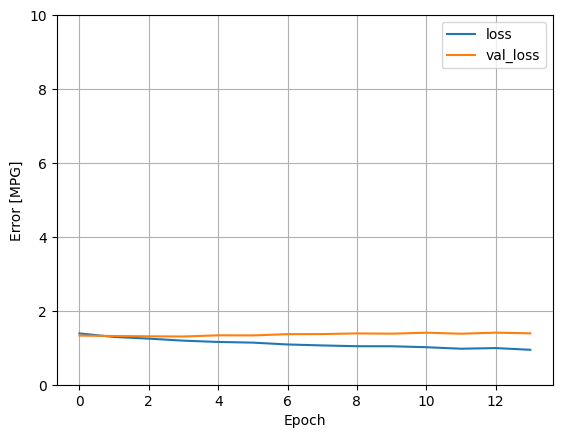

7/7 [==============================] - 0s 917us/step
Label:      2
Prediction: 2
Label:      2
Prediction: 3
Label:      2
Prediction: 0
Label:      3
Prediction: 3
Label:      2
Prediction: 2
Label:      3
Prediction: 3
Label:      1
Prediction: 1
Label:      1
Prediction: 1
Label:      2
Prediction: 2
Label:      1
Prediction: 3
Label:      3
Prediction: 2
Label:      0
Prediction: 0
Label:      0
Prediction: 1
Label:      0
Prediction: 2
Label:      3
Prediction: 3
Label:      1
Prediction: 2
Label:      2
Prediction: 2
Label:      2
Prediction: 0
Label:      1
Prediction: 2
Label:      2
Prediction: 2
Label:      2
Prediction: 2
Label:      1
Prediction: 0
Label:      2
Prediction: 2
Label:      1
Prediction: 2
Label:      2
Prediction: 0
Label:      2
Prediction: 2
Label:      2
Prediction: 2
Label:      2
Prediction: 3
Label:      2
Prediction: 2
Label:      1
Prediction: 3
Label:      3
Prediction: 0
Label:      2
Prediction: 1
Label:      1
Prediction: 1
Label:      2
Predictio

FileNotFoundError: [Errno 2] No such file or directory: 'The-Blue-Danube-Waltz.mid'

In [11]:
from tensorflow import keras
from keras import metrics
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import pretty_midi as pm


# Define the model architecture
normalizer = keras.layers.BatchNormalization()
model = keras.Sequential([
    normalizer,
    keras.layers.Dense(19, activation='relu'), # There are 20 variables in the feature matrix
    keras.layers.Dense(14, activation='relu'), # 2/3 the input layer + 1
    keras.layers.Dense(num_classes, activation='softmax')
])

"""
optimizer="adam": The optimizer algorithm to use during training. 
Adam optimizer is chosen, which is a popular optimization algorithm known for its efficiency.

loss='categorical_crossentropy': The loss function used to measure the discrepancy between the 
predicted output and the true output labels. Categorical cross-entropy is suitable for
multi-class classification tasks.

metrics=['accuracy']: The metric(s) to be evaluated during training and testing. 
Accuracy is a commonly used metric to assess the model's performance.
"""

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

"""
training_features, train_labels: Input features and corresponding labels for model training.

validation_features, val_labels: Validation set used to monitor the model's performance 
                                         during training.

batch_size=32: Number of samples per gradient update. Training data is divided into batches, 
               and the model's weights are updated after each batch.

epochs=50: Number of times the model will iterate over the entire training dataset.

callbacks: EarlyStopping to stop training if the validation loss does not improve for a certain 
           number of epochs, and ModelCheckpoint to save the best model based on validation loss.
"""

# Encode the training and validation labels using one-hot encoding
train_labels_encoded = to_categorical(training_labels)
val_labels_encoded = to_categorical(validation_labels)

history = model.fit(x=training_features, y=train_labels_encoded, 
                    validation_data=(validation_features, val_labels_encoded),
                    batch_size=10, epochs=200, verbose=2,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
                               keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)])

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.legend()
plt.grid(True)
plt.show()
# Save the entire model to an h5 file
model.save("my_model.h5")

# Use the loaded model for prediction
real_labels = [0,0,0,0]
predicted_labels = [0,0,0,0]
correct = [0,0,0,0]

preds = model.predict(test_features)

for i in range(len(test_labels)):
    real = test_labels[i]
    prediction = np.argmax(preds[i])
    real_labels[real] += 1
    predicted_labels[prediction] += 1

    print("Label:      " + str(real))
    print("Prediction: " + str(prediction))

    if (real == prediction):
        correct[real] += 1

print("Total labels in test data: ", real_labels)
print("Total labels in pred data: ", predicted_labels)
print("correct labels in test data: ", correct)
probabilities = [i / j for i, j in zip(correct, predicted_labels)]
print("prediction probabilities: ", probabilities)
    
danube_midi = pm.PrettyMIDI('The-Blue-Danube-Waltz.mid')
danube_feats = get_features(danube_midi)
danube_feats = np.asarray(danube_feats)
danube_feats = np.expand_dims(danube_feats, axis = 0)
print('danube: ', np.argmax(model.predict(danube_feats)))
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_features, to_categorical(test_labels))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

In [ ]:
from tensorflow import keras
from keras import metrics
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import pretty_midi as pm
import torch.nn as nn

class Network(nn.Module):
    def __init__(self, num_features):
        super(Network, self).__init__()
        self.layer1 = nn.Linear(num_features, 42)
        self.layer2 = nn.Linear(42, 16)
        self.layer3 = nn.Linear(16, 4)